# Taxi Orders Time Series Prediction

Project Report by Allentine Paulis

# Table of Contents
* [Project Description](#description)
* [Project Instructions](#instruction)
* [Data](#data)
* [Step 1. Data Preparation](#preparation)
* [Step 2. Data Analysis](#analysis)
* [Step 3. Model Training](#training)
* [Step 4. Model Testing](#testing)  
* [Step 5. Overall conclusion](#allconclusion)

# Project description <a class="anchor" id="description"></a>

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.


# Project instructions  <a class="anchor" id="instruction"></a>

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.



# Data  <a class="anchor" id="data"></a>

The data is stored in file `https://code.s3.yandex.net/datasets/taxi.csv`. 

The number of orders is in the '*num_orders*' column.

## Preparation <a class="anchor" id="preparation"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
df.duplicated().sum()

0

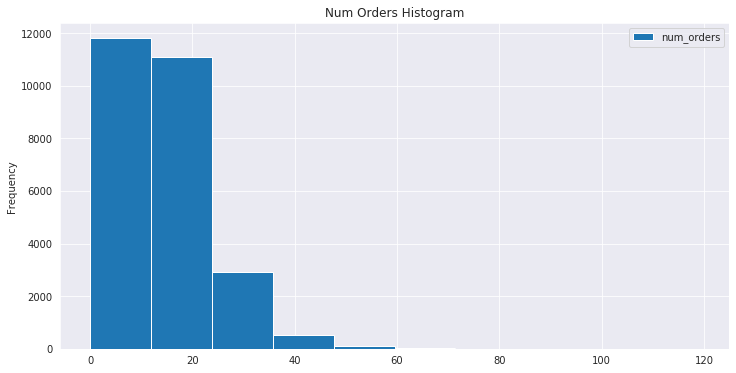

In [8]:
df.plot(kind='hist')
plt.title('Num Orders Histogram')
plt.show()

Right skewed distribution.

Preparing the data.

- Parse the date data type into datetime
- Set the table index equal to the Datetime column

In [9]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


check if the index is ordered

In [11]:
df.index.is_monotonic

True

### Conclusion
- Data has 26496 rows and 2 columns which are datetime and num_orders
- Date column data type should be datetime data type
- no missing values
- no duplicated
- Data has right skewed distribution, with most of time passengers between 10-20, and few times are more than 20.
- Parse the date data type into datetime
- Set the table index equal to the Datetime column
- the index is ordered

## Analysis <a class="anchor" id="analysis"></a>

Resampling for 1 hour, week and month

In [12]:
df_monthly = df.resample('1M').sum()
df_weekly = df.resample('1W').sum()
df_hourly = df.resample('1H').sum()

Let's look at the statistics of orders broken down by month

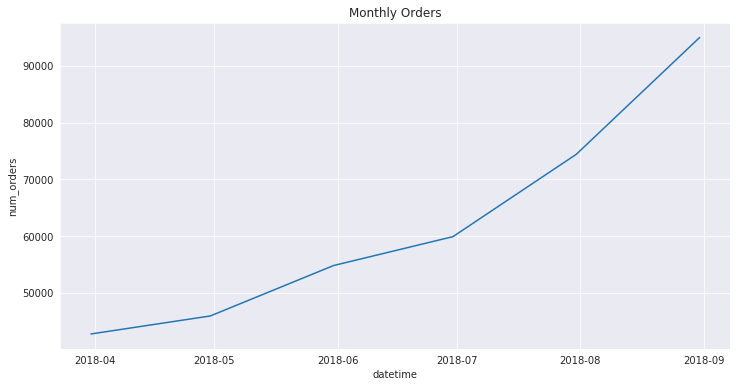

In [13]:
sns.lineplot(x=df_monthly.index,y=df_monthly['num_orders'])
plt.title('Monthly Orders')
plt.show()

Let's look at the statistics of orders broken down by week

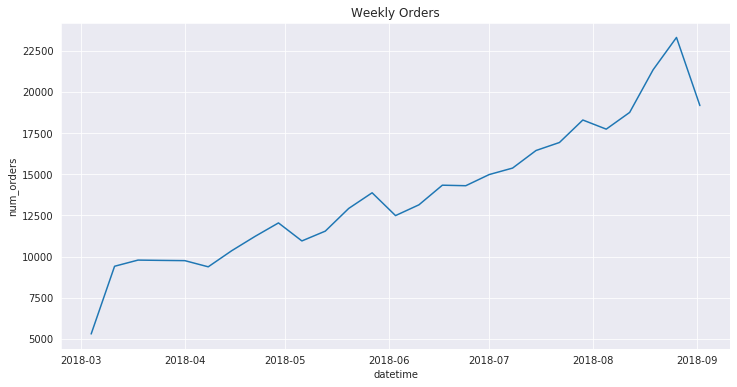

In [14]:
sns.lineplot(x=df_weekly.index,y=df_weekly['num_orders'])
plt.title('Weekly Orders')
plt.show()

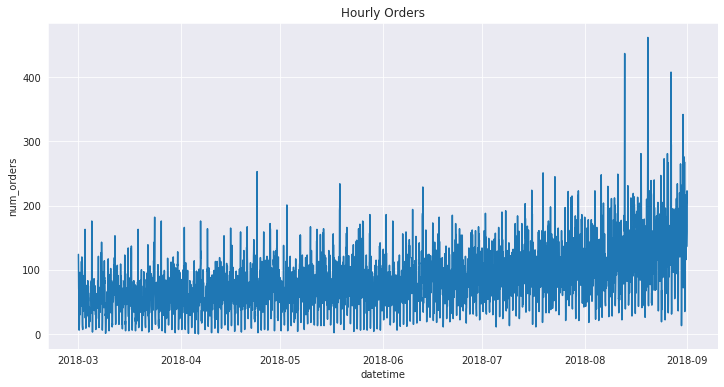

In [15]:
sns.lineplot(x=df_hourly.index,y=df_hourly['num_orders'])
plt.title('Hourly Orders')
plt.show()

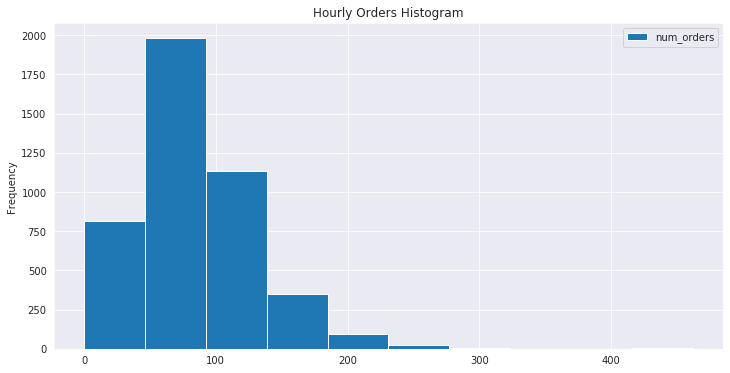

In [16]:
df_hourly.plot(kind='hist')
plt.title('Hourly Orders Histogram')
plt.show()

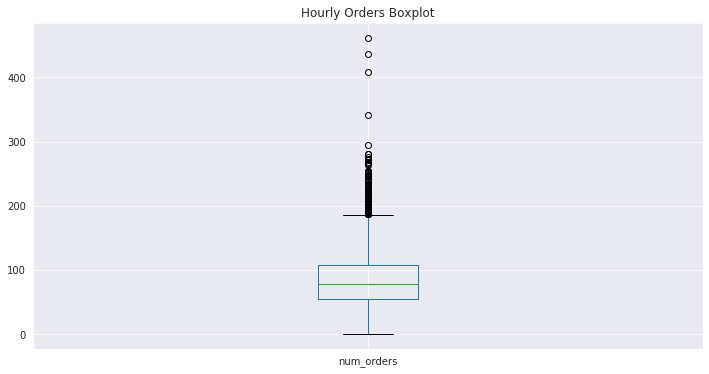

In [17]:
df_hourly.boxplot()
plt.title('Hourly Orders Boxplot')
plt.show()

In [18]:
df_hourly.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


- in general, the trend is going up, more people are ordering taxi
- the orders depends on the hour of the day, there seems a seasonality on the orders
- variance between hours seems high
- It has the right skewed distribution, median is lower than mean
- the average order is 85 and most of the time are between 55-105 and few times are more than 180 with some group of hours between 180-300 orders per hour



Let's look at the moving average and the moving standard deviation

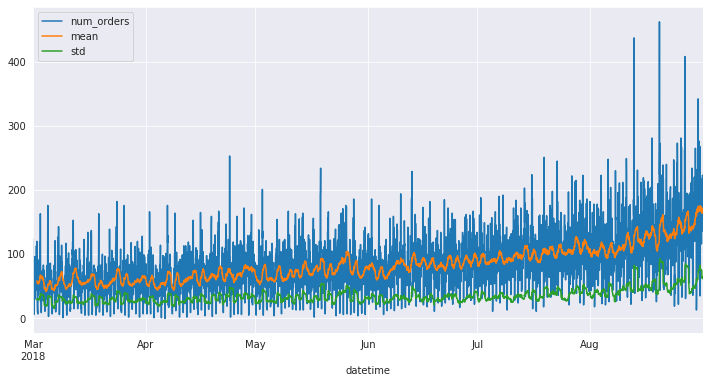

In [19]:
df_hourly['mean'] = df_hourly['num_orders'].rolling(25).mean()
df_hourly['std'] = df_hourly['num_orders'].rolling(25).std()
df_hourly.plot()

In [20]:
df_plot = df.copy()
df_plot = df_plot.resample('1H').sum()
df_plot['rolling_mean'] = df_plot['num_orders'].shift().rolling(12).mean()
df_plot['std'] = df_plot['num_orders'].rolling(12).std()
df_plot = df_plot.dropna()

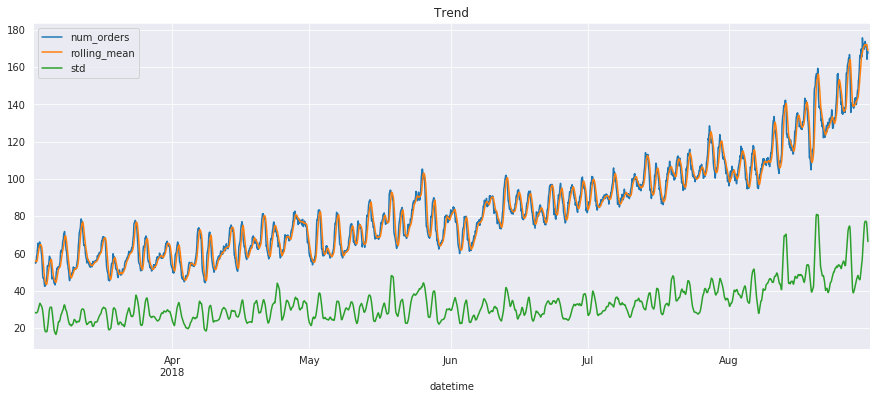

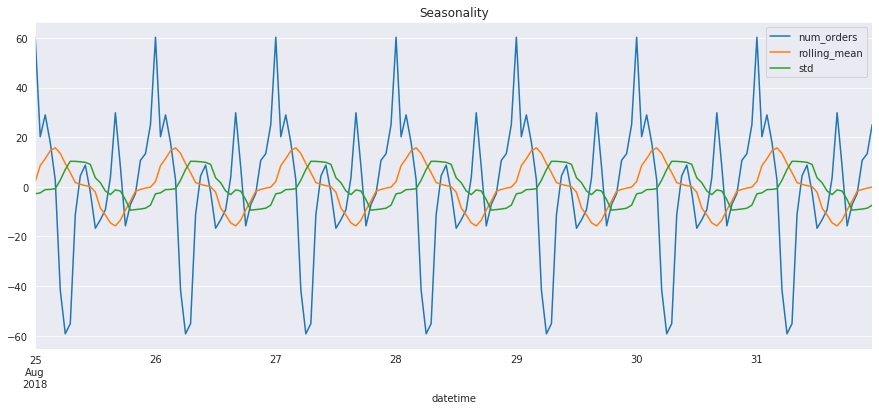

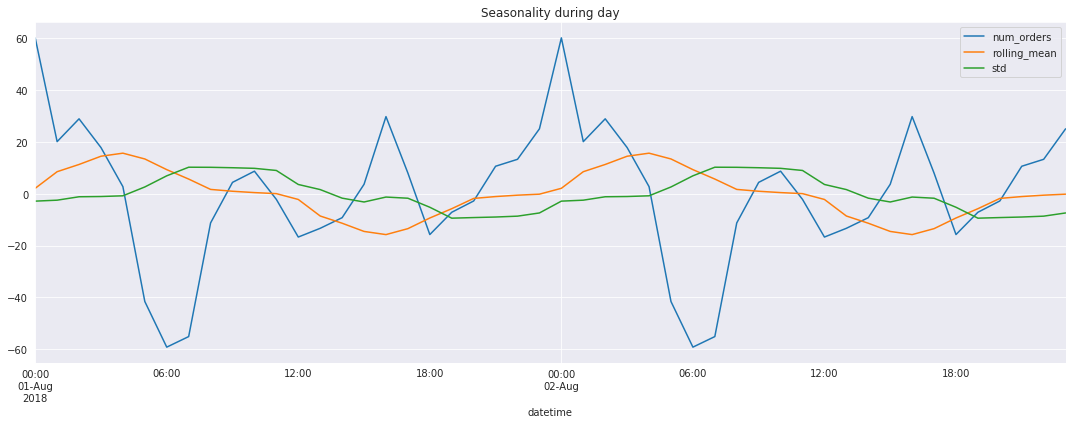

In [21]:
df_decomposed = seasonal_decompose(df_plot)
df_decomposed.trend.plot(title='Trend', figsize=(15,6))
df_decomposed.seasonal.tail(24*7).plot(title='Seasonality', figsize=(15,6))
plt.figure(figsize=(15, 6))
df_decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca(), figsize=(15,6))
plt.title('Seasonality during day')
plt.tight_layout()

### Conclusion
- From Trend chart, the number of orders is gradually increasing.
- From Seasonality chart broken by week, it shows how the number of orders on weekends is less than on other days.
- From Seasonality during day, the number of orders in the morning are much less than at other times, while the orders are from before and after work time and also after midnight.

## Model Training <a class="anchor" id="training"></a>

Using resampling for 1 hour

In [22]:
df = df.resample('1H').sum()

Create Features

In [23]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 9, 9)

In [24]:
df.describe()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
count,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4408.000000,4407.000000,4407.000000
mean,84.422781,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.236162,84.228954,84.320198
std,45.023853,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,44.831888,44.834421,30.263125
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.888889
25%,54.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.555556
50%,78.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.888889
75%,107.000000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.111111
max,462.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,223.111111


Splitting the data into train and test sample

In [25]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

Define the features and the target feature for the training and test samples

In [26]:
X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [27]:
train.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 09:00:00,69,3,9,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.666667
2018-03-01 10:00:00,64,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,44.555556
2018-03-01 11:00:00,96,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,42.222222
2018-03-01 12:00:00,30,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,45.000000
2018-03-01 13:00:00,32,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,41.000000


In [28]:
test.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,103.000000
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,105.111111
2018-08-13 16:00:00,144,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,117.222222
2018-08-13 17:00:00,152,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,128.888889
2018-08-13 18:00:00,104,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,135.666667


In [29]:
print('Training sample size:', X.shape)
print('Test sample size:', X_test.shape)

Training sample size: (3965, 12)
Test sample size: (442, 12)


### LinearRegression

In [30]:
%%time
lr = LinearRegression()
lr.fit(X,y)
lr_predictions = lr.predict(X_test)
print('RMSE:', mean_squared_error(y_test, lr_predictions)**0.5)

RMSE: 54.08758434757491
CPU times: user 8.93 ms, sys: 296 µs, total: 9.23 ms
Wall time: 4.83 ms


### Decision Tree Regressor

In [31]:
%%time
dtr = DecisionTreeRegressor()
dtr.fit(X,y)
dtr_predictions = dtr.predict(X_test)
print('RMSE:', mean_squared_error(y_test, dtr_predictions)**0.5)

RMSE: 61.48216457710295
CPU times: user 73.1 ms, sys: 40.5 ms, total: 114 ms
Wall time: 145 ms


### Random Forest Regressor

In [32]:
%%time
rfr = RandomForestRegressor(random_state=12345)
rfr.fit(X,y)
rfr_predictions = rfr.predict(X_test)
print('RMSE:', mean_squared_error(y_test, rfr_predictions)**0.5)

RMSE: 49.82565599643534
CPU times: user 278 ms, sys: 4.25 ms, total: 282 ms
Wall time: 292 ms


### XGBRegressor

In [33]:
%%time
xgb = XGBRegressor()
xgb.fit(X,y)
xgb_predictions = xgb.predict(X_test)
print('RMSE:', mean_squared_error(y_test, xgb_predictions)**0.5)

[22:14:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 47.79454701130124
CPU times: user 277 ms, sys: 12 ms, total: 289 ms
Wall time: 303 ms


### CatBoostRegressor

In [34]:
%%time
cbr = CatBoostRegressor(loss_function="RMSE", verbose=False)
cbr.fit(X,y)
cbr_predictions = cbr.predict(X_test)
print('RMSE:', mean_squared_error(y_test, cbr_predictions)**0.5)

RMSE: 44.90669888485379
CPU times: user 18.4 s, sys: 2.7 s, total: 21.1 s
Wall time: 22.5 s


### LGBM Regressor

In [35]:
%%time
lgbm = LGBMRegressor(random_state=12345)
lgbm.fit(X,y)
lgbm_predictions = lgbm.predict(X_test)
print('RMSE:', mean_squared_error(y_test, lgbm_predictions)**0.5)

RMSE: 43.820303611464006
CPU times: user 209 ms, sys: 1.82 ms, total: 211 ms
Wall time: 208 ms


The best model with the RMSE value and fast time running is LGBM Regressor, let's check with hyperparameter tuning.

In [36]:
estimators = [50,100,200,300]
leaves = [2,5,7,12]

for estim, leave in zip(estimators, leaves):
    lgbm_model = LGBMRegressor(n_estimators=estim, num_leaves=leave,random_state=12345)
    lgbm_model.fit(X,y)
    predictions = lgbm_model.predict(X)
    rmse = mean_squared_error(y, predictions)**0.5
    print('RMSE with n_estimators : {} and num_leaves: {} is {}'.format(estim, leave, rmse))

RMSE with n_estimators : 50 and num_leaves: 2 is 29.447685769072727
RMSE with n_estimators : 100 and num_leaves: 5 is 22.159400472645576
RMSE with n_estimators : 200 and num_leaves: 7 is 19.212092776098753
RMSE with n_estimators : 300 and num_leaves: 12 is 14.89407898647034


### Conclusion
- LightGBM showed the best result on the training set with best RMSE and best time and we will work further with this model

## Model Testing <a class="anchor" id="testing"></a>

In [37]:
%%time
model = LGBMRegressor(n_estimators=300,
                        num_leaves=12,
                        objective='regression',
                        random_state= 12345
                        )
model.fit(X,y)
predictions = model.predict(X_test)
print('RMSE on test sample:', mean_squared_error(y_test, predictions)**0.5)

RMSE on test sample: 43.92340606427539
CPU times: user 262 ms, sys: 18.9 ms, total: 281 ms
Wall time: 290 ms


### Feature Importance


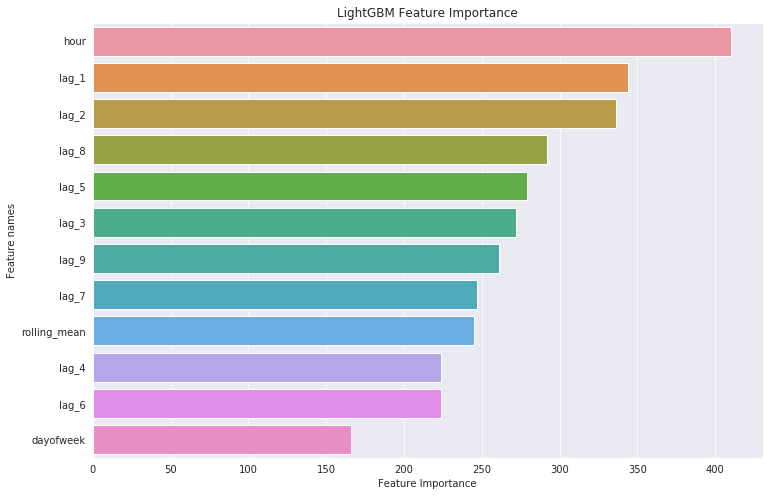

In [38]:
feature_importance = np.array(model.feature_importances_)
feature_names = np.array(X_test.columns)

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':feature_importance}
df_fi = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
df_fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)

plt.figure(figsize=(12,8))
sns.barplot(x=df_fi['feature_importance'], y=df_fi['feature_names'])
plt.title('LightGBM Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature names')
plt.show()

Display on the chart the real number of orders per day and predicted by our model.

In [39]:
orders_real = y_test.copy()
orders_predictions = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_result = pd.merge(orders_real, orders_predictions, how = 'left', left_index = True, right_index = True)

In [40]:
df_result.sample(5)

,num_orders,predictions
datetime,,
2018-08-24 23:00:00,173,145.347795
2018-08-19 03:00:00,169,124.798980
2018-08-13 16:00:00,144,126.408214
2018-08-24 19:00:00,113,142.336755
2018-08-31 21:00:00,159,155.520497


In [41]:
df_result['predictions'] = df_result['predictions'].astype('int64')
df_result['predictions']

datetime
2018-08-13 14:00:00    105
2018-08-13 15:00:00    102
2018-08-13 16:00:00    126
2018-08-13 17:00:00    120
2018-08-13 18:00:00    106
                      ... 
2018-08-31 19:00:00    137
2018-08-31 20:00:00    141
2018-08-31 21:00:00    155
2018-08-31 22:00:00    155
2018-08-31 23:00:00    158
Freq: H, Name: predictions, Length: 442, dtype: int64

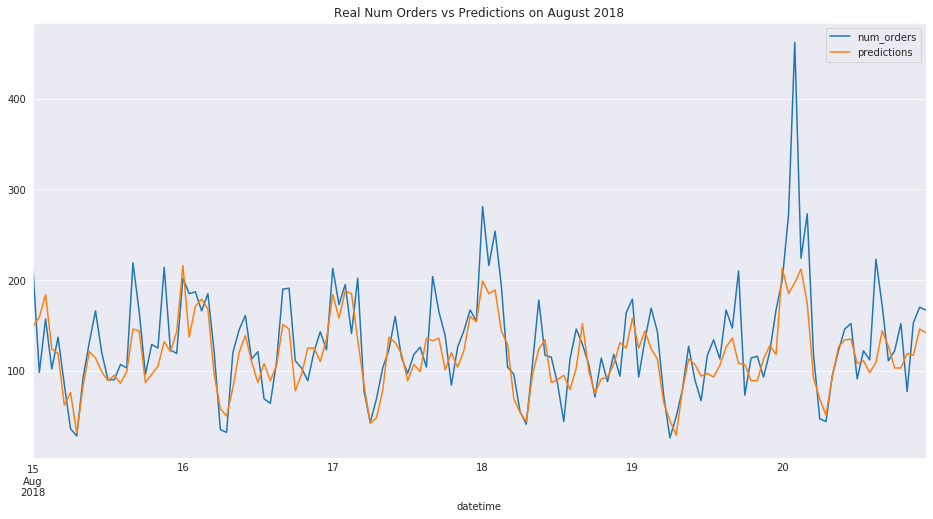

In [42]:
df_result['2018-08-15':'2018-08-20'].plot(figsize=(16,8))
plt.title('Real Num Orders vs Predictions on August 2018')
plt.show()

### Conclusion
- The model fits pretty well with the real orders
- We got the best RMSE result of 43.92 on the test sample from LGBM Regressor model with fast time running result of 340 ms.


## Overall Conclusion <a class="anchor" id="allconclusion"></a>

- From the analysis and the model, we saw that the trend of taxi orders is going up.
- The number of orders in the morning are much less than at other times, while the orders are coming from before and after work time and also after midnight.
- The number of orders on weekends is less than on other days.
- The model predicts the seasonability and the trend can be noticed.
- In general our LGBM Regressor model has pretty good results and fast, it fits fairly well into real orders. 